In [1]:
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import argparse
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import math
import wandb

from wandb.integration.keras.callbacks import WandbMetricsLogger, WandbModelCheckpoint


nmf = joblib.load("../Models/nmf/nmf-model-to.pkl")

data = np.load("../Data/LPS/classifier_lps_data.npy")
Y = np.load("../Data/LPS/classifier_lps_labels.npy")
# data = data.astype(np.float32)
print(data.shape)

2025-10-31 18:26:19.773944: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(3315, 67499)


In [ ]:
X = nmf.transform(data)
print(X.shape)

(3315, 200)


/home/vmuser/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


In [3]:
# wandb.init(
#     project="MLPClassifier",
#     config={
#         "hidden_size": 64,
#         "activation": "relu",
#         "dropout": 0.5,
#         "output_activation": "softmax",
#         "optimizer": "adam",
#         "loss": "sparse_categorical_crossentropy",
#         "metric": "accuracy",
#         "epochs": 50,
#         "batch_size": 32,
#         "learning_rate": 0.001
#     }
# )

# config = wandb.config

In [ ]:
class MLPClassifier(tf.keras.Model):
    def __init__(self, input_dim, num_classes=2, hidden_size=64, dropout_rate=0.5):
        super().__init__()
        self.hidden = layers.Dense(hidden_size, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.hidden(inputs)
        x = self.dropout(x)
        return self.classifier(x)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)
print(f'Training data shape: {X_train.shape}')
print(f'Val data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (2320, 200)
Val data shape: (331, 200)
Test data shape: (664, 200)


In [6]:
print("NaN in training data:", np.isnan(X).any())
print("Input range:", np.min(X), "to", np.max(X))

NaN in training data: False
Input range: 0.0 to 0.11991014


In [7]:
input_dim = X_train.shape[1]
model = MLPClassifier(input_dim=input_dim,hidden_size=64)

2025-10-31 18:26:57.187571: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=10,
    restore_best_weights=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            )

print("Training started....")
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,    
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping,
            #    WandbMetricsLogger(),
            #    WandbModelCheckpoint("nmf_model_{epoch:02d}_{batch:02d}.keras",save_best_only=True,save_weights_only=False,monitor='accuracy')
               ]
)
# wandb.finish()
print("Training completed!")

Training started....
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5082 - loss: 0.6928 - val_accuracy: 0.4985 - val_loss: 0.6921
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5224 - loss: 0.6910 - val_accuracy: 0.6647 - val_loss: 0.6894
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6013 - loss: 0.6877 - val_accuracy: 0.5710 - val_loss: 0.6857
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5957 - loss: 0.6822 - val_accuracy: 0.6647 - val_loss: 0.6792
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 0.6725 - val_accuracy: 0.6828 - val_loss: 0.6697
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6724 - loss: 0.6607 - val_accuracy: 0.6344 - val_loss: 0.6593
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6569 - loss: 0.6498 - val_accuracy: 0.6586 - val_loss: 0.6494
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6789 - loss: 0.6362 - val_accurac

In [11]:
model.summary()

Model: "mlp_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,984 (152.29 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,990 (101.53 KB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7425 - loss: 0.5262 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
TN: 296, FP: 36, FN: 135, TP: 197
AUC: 0.8183880098708085


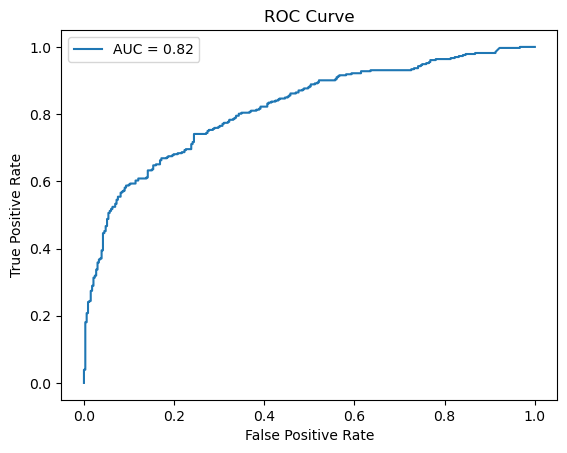

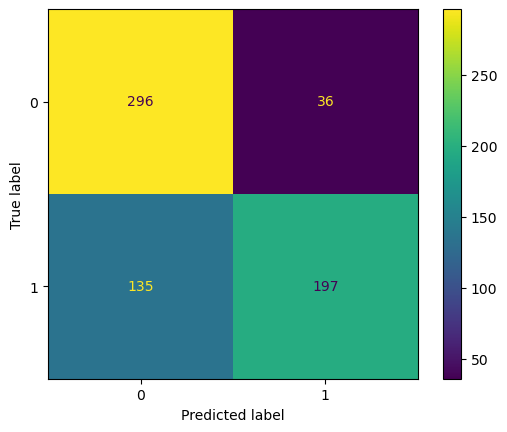

Test loss: 0.526232898235321
Test Accuracy 0.7424699068069458


In [12]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

loss, accuracy = model.evaluate(X_test, y_test)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

if len(np.unique(y_test)) == 2:
    auc = roc_auc_score(y_test, y_pred_probs[:, 1])
    print(f'AUC: {auc}')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f'Test loss: {loss}')
print(f'Test Accuracy {accuracy}')